In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import numpy as np
import scipy
from scipy.optimize import curve_fit

#### load data

In [2]:
input_csv = "vidro-1kHz-40mBias7.csv"

df = pd.read_csv(input_csv, comment='#', names=['x', 'y', 'p', 't'])
df.head()

,x,y,p,t
0,719,511,1,5168
1,720,511,1,5168
2,721,511,1,5168
3,722,511,1,5168
4,723,511,1,5168


### Filter (small region just to calculate phase per pixel) and see the ROI


Number of data points: 1154
             x    y  p        t
132776036  720  298  0  1100800
132776046  725  297  0  1100800
132776050  723  297  1  1100800
132776066  720  296  1  1100800
132776067  724  296  1  1100800
...        ...  ... ..      ...
132782533  722  144  1  1100850
132782543  720  147  1  1100850
132782544  721  147  1  1100850
132782545  723  147  1  1100850
132782546  725  147  1  1100850

[1154 rows x 4 columns]
Time range: 1100800 to 1100850
Filtered data:
     x    y  p        t
0  720  298  0  1100800
1  725  297  0  1100800
2  723  297  1  1100800
3  720  296  1  1100800
4  724  296  1  1100800
Number of events: 1154
Density array shape: (205588,)
Density indices shape: (1154,)
Max density index: 169933
Min density index: 159
Densities size: 205588
Density indices (first 10): [74160 73748 73748 73336 73336 74984 74984 74984 74984 75396]


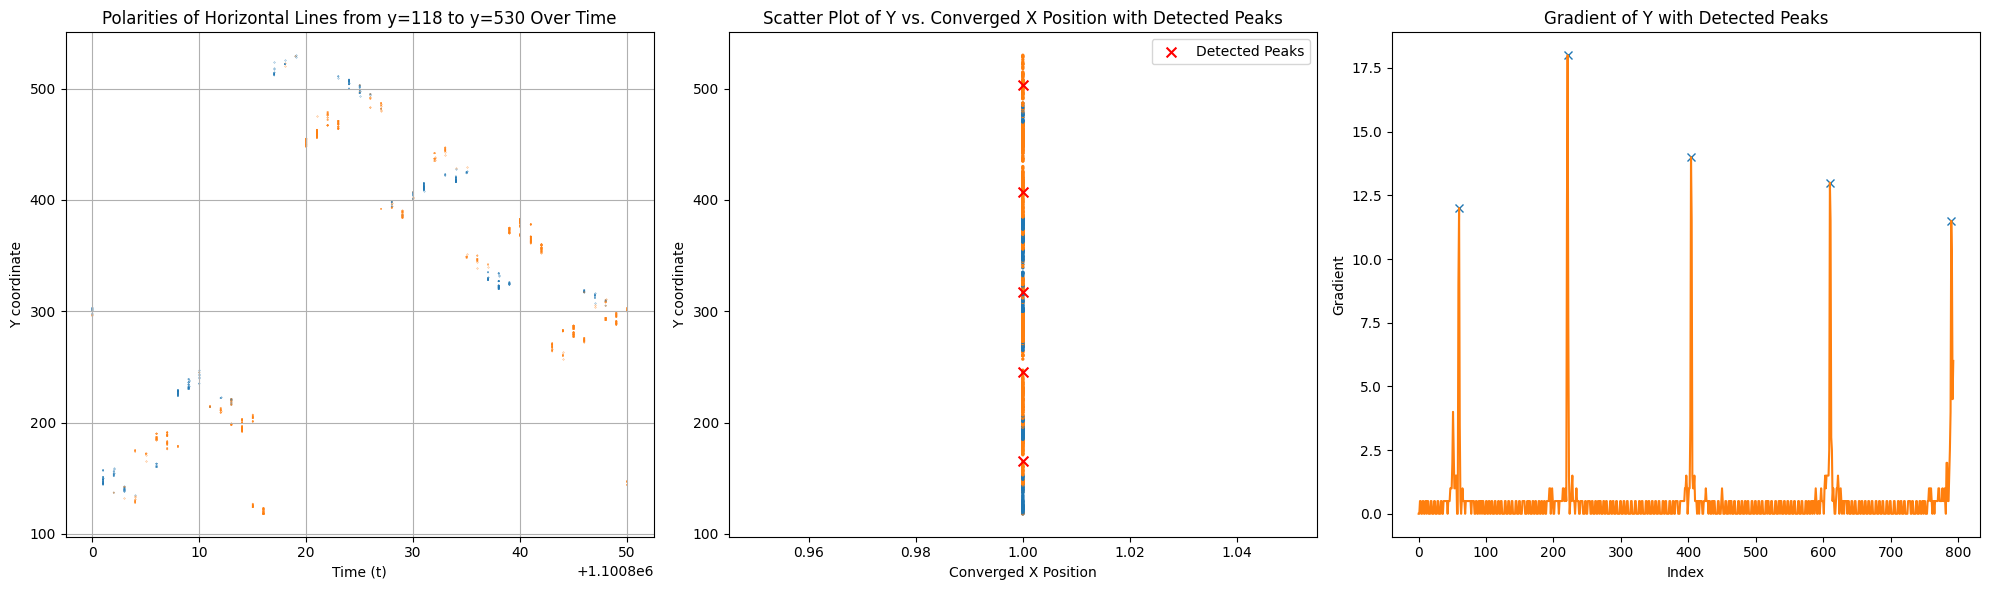

[165 245 317 407 503]


In [19]:
from polarityarea2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Define the parameters
tmin = 1100800
tmax = 1100850
ymin = 118
ymax = 530
xmin = 720
xmax = 725
polarity = None

# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()

# Sort the data based on y
x = line_df['x'].to_numpy()
y = line_df['y'].to_numpy()
t = line_df['t'].to_numpy()
p = line_df['p'].to_numpy()

idx = np.argsort(y)
x = x[idx]
y = y[idx]
t = t[idx]
p = p[idx]

# Separate the data based on polarity
yp = y[p == 1]
yn = y[p == 0]

# Calculate the gradient of yp
gradyp = np.gradient(yp)

# Find peaks in the gradient of the y data for polarity = 1
peaksidx, _ = find_peaks(gradyp, distance=10, prominence=2)

# Create the ysplit and phisplit arrays
ysplit = yp[peaksidx]
phisplit = np.arange(0, 2 * np.pi * len(ysplit), 2 * np.pi)

# Create a subplot grid with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# First plot: Using plot_lines_polarity_over_time
plot_lines_polarity_over_time(input_csv, xmin, xmax, ymin, ymax, tmin, tmax, polarity, ax=ax1)

# Second plot: Scatter plot of y vs. position (converged x)
colors = ["C0", "C1"]
colors_vec = [colors[p] for p in line_df['p']]

# Set all x positions to the same value (e.g., 1) to align them vertically
converged_x = np.ones(len(t))
ax2.scatter(converged_x, y, s=2, c=colors_vec)

# Overlay the detected peaks on the scatter plot
ax2.scatter(converged_x[peaksidx], yp[peaksidx], s=50, c="red", marker="x", label="Detected Peaks")

# Configure labels and title for the second plot
ax2.set_xlabel('Converged X Position')
ax2.set_ylabel('Y coordinate')
ax2.set_title('Scatter Plot of Y vs. Converged X Position with Detected Peaks')
ax2.legend()

# Third plot: Gradient of y with peaks
ax3.plot(peaksidx, abs(gradyp[peaksidx]), "x")
ax3.plot(gradyp)
ax3.set_title('Gradient of Y with Detected Peaks')
ax3.set_xlabel('Index')
ax3.set_ylabel('Gradient')

plt.tight_layout()
plt.show()

print(ysplit)


In [4]:
phisplit

array([ 0.        ,  6.28318531, 12.56637061, 18.84955592, 25.13274123])

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651 1.57079633 1.64933614 1.72787596 1.80641578
 1.88495559 1.96349541 2.04203522 2.12057504 2.19911486 2.27765467
 2.35619449 2.43473431 2.51327412 2.59181394 2.67035376 2.74889357
 2.82743339 2.9059732  2.98451302 3.06305284 3.14159265 3.22013247
 3.29867229 3.3772121  3.45575192 3.53429174 3.61283155 3.69137137
 3.76991118 3.848451   3.92699082 4.00553063 4.08407045 4.16261027
 4.24115008 4.3196899  4.39822972 4.47676953 4.55530935 4.63384916
 4.71238898 4.7909288  4.86946861 4.94800843 5.02654825 5.10508806
 5.18362788 5.26216769 5.34070751 5.41924733 5.49778714 5.57632696
 5.65486678 5.73340659 5.81194641 5.89048623 5.96902604 6.04756586
 6.12610567 6.20464549 0.         0.07757019 0.15514038 0.23271057
 0.31028076 0.38785094 0.46542113 0.54299132 0.62056151 0.6981

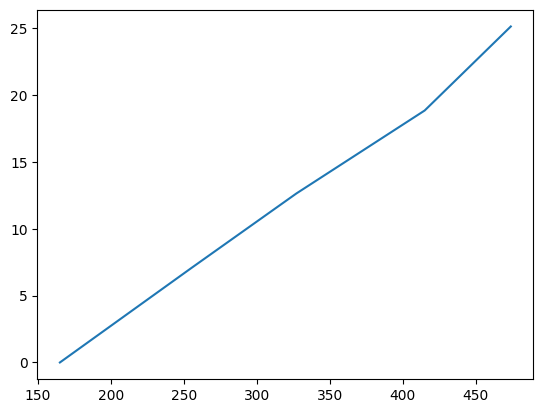

In [5]:
yroi = np.arange(ysplit[0], ysplit[-1] + 1)
phiroi = np.interp(yroi, ysplit, phisplit)
plt.plot(yroi, phiroi)
phiroi = np.mod(phiroi, 2 * np.pi) #between 0,2pi
print(phiroi)

### filter data (main data- bigger time period)

In [6]:
%matplotlib inline
# Define the parameters
tmin = 1100000
tmax = 2000000
ymin = yroi[0]
ymax = yroi[-1]


# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()


Number of data points: 4626310
             x    y  p        t
132676902  720  345  1  1100000
132676912  720  337  1  1100000
132676913  722  337  1  1100000
132676914  724  337  1  1100000
132676927  723  336  1  1100000
...        ...  ... ..      ...
167101512  725  463  1  1384255
167101521  720  473  1  1384255
167101522  722  473  1  1384255
167101523  723  473  1  1384255
167101524  724  473  1  1384255

[4626310 rows x 4 columns]
Time range: 1100000 to 1384255


### phase per pixel method application

yp: [180 178 177 ... 308 308 308]
phiroi: 1.3413541667012598
phase: [1.34135417 1.20015899 1.1295614  ... 6.17669064 6.17669064 6.17669064]
3296323
3296323


(0.0, 2000.0)

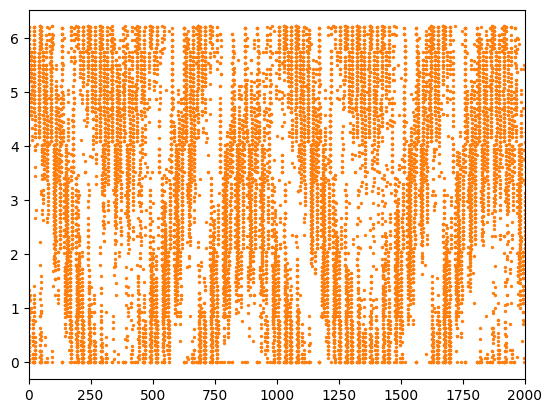

In [7]:

colors = ["C0", "C1"]

colors_vec = [colors[p] for p in line_df['p']]
x = line_df['x']
p = line_df['p']
t = line_df['t']
y = line_df['y']

x = np.array(x)
y = np.array(y)
p = np.array(p)
t = np.array(t)

idx = np.argsort(t)

x = x[idx]
y = y[idx]
t = t[idx]
p = p[idx]

t = t-t[0]

yp = y[p==1]
tp = t[p==1]
yn = y[p==0]

tp = tp-tp[0]

yp = yp-ymin

phase = np.array([phiroi[yi] for yi in yp])

print("yp:", yp)
print("phiroi:", phiroi[180])
print("phase:", phase)
##yp = np.mod(yp, pixels_per_period)
#yp = np.mod(yp, 84)

tp_uniques = np.unique(tp)

##phase = yp*phaseperpixel
print(len(tp))
print(len(phase))
plt.scatter(tp, phase, s=2, c="C1")
plt.xlim(0,2000)

### Calculation of phase (centroids)

In [8]:
tp_uniques = np.unique(tp)
centroid_y = []
tval_vec = []

for i,tval in enumerate(tp_uniques):
    yval = phase[tp==tval]
    ycomplex = np.cos(yval)+1j*np.sin(yval)

    ymean = np.angle(np.mean(ycomplex))

    
    #print(i, ymean)
    centroid_y.append(ymean)
    tval_vec.append(tval)

    if i > 5500:
        break

centroid_y = np.array(centroid_y)
tval_vec = np.array(tval_vec)


In [9]:
centroid_y,tval_vec

(array([ 0.91670598,  0.38099305, -0.20014471, ..., -2.0943951 ,
        -1.83583357,  0.43508143]),
 array([   0,    1,    2, ..., 7758, 7759, 7763], dtype=int64))

### phases of events over time

(0.0, 2000.0)

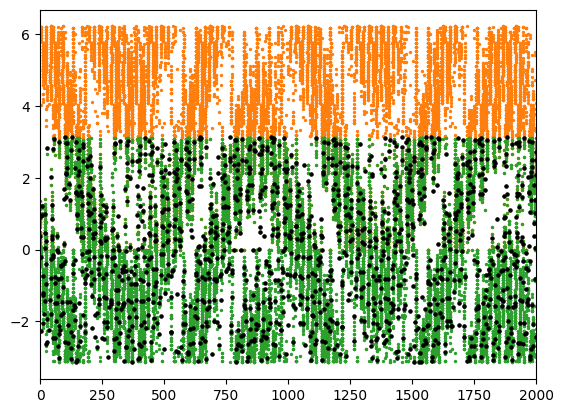

In [10]:
plt.scatter(tp, phase, s=2, c="C1")
plt.scatter(tp, np.mod(phase+np.pi, 2*np.pi)-np.pi, s=2, c="C2")
plt.scatter(tval_vec, centroid_y, s=5, c="k")
plt.xlim(0,2000)

### plot of the real and imaginary parts of complex numbers representing phase centroids

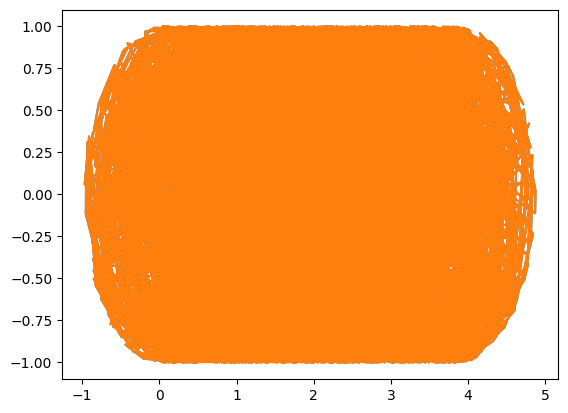

In [11]:
phase_complex = np.cos(centroid_y)+1j*np.sin(centroid_y)

#phase_complex = phase_complex[:100]

plt.plot(phase_complex.real+tval_vec/2000, phase_complex.imag, '-')
plt.plot(phase_complex.real+tval_vec/2000, phase_complex.imag, '-')


### Kalman filter to smooth the phase data derived from the centroid phases

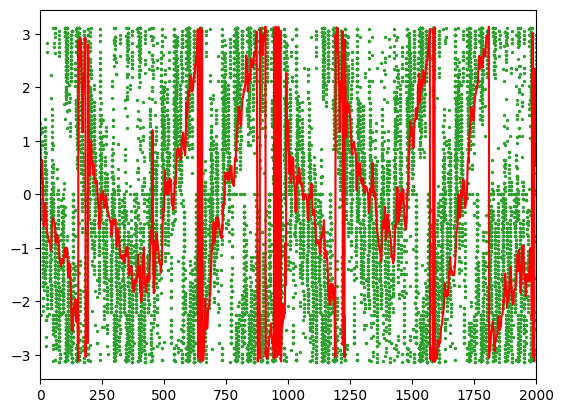

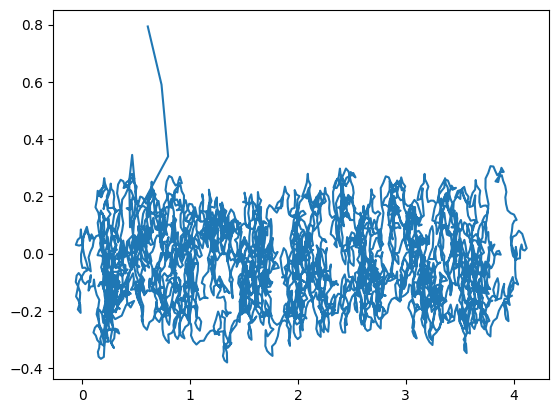

In [12]:
from kalman import KalmanTracking


Track = KalmanTracking()
Track.cov = 0.5 #Sets the initial covariance, representing the uncertainty in the initial state estimate.
Track.error_proc = 0.0001 #Sets the estimated process error, representing how much you expect the process to vary between steps.
Track.error_measurement = 0.1+0.1j #Sets the estimated measurement error, which includes both real and imaginary components.

complex_kalman = np.array([Track(c) for c in phase_complex])
phase_kalman = np.angle(complex_kalman)
#plt.plot(phase_complex.real+tval_vec/10000, phase_complex.imag, '.')
#plt.plot(phase_kalman.real+tval_vec/10000, phase_kalman.imag, '.')


plt.figure()
plt.scatter(tp, np.mod(phase+np.pi, 2*np.pi)-np.pi, s=2, c="C2")
#plt.scatter(tval_vec, centroid_y, s=5, c="k")
plt.plot(tval_vec, phase_kalman, c="r")
plt.xlim(0,2000)

plt.figure()
plt.plot(complex_kalman.real+tval_vec/2000, complex_kalman.imag, '-')


12.386272089963754

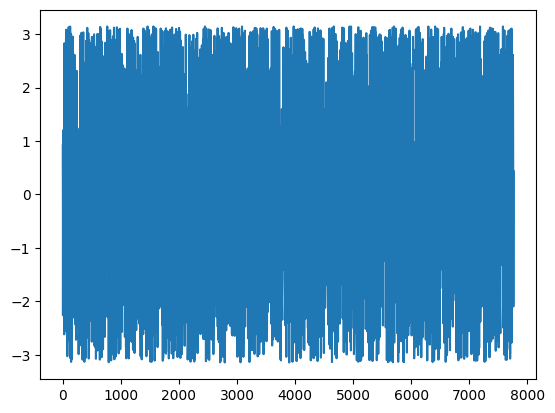

In [13]:
plt.plot(tval_vec, centroid_y)




np.ptp(np.diff(centroid_y)).max()


### Phase Unwrapping and Continuous Phase Analysis


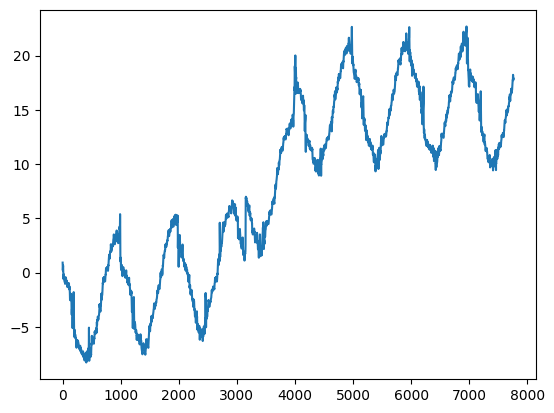

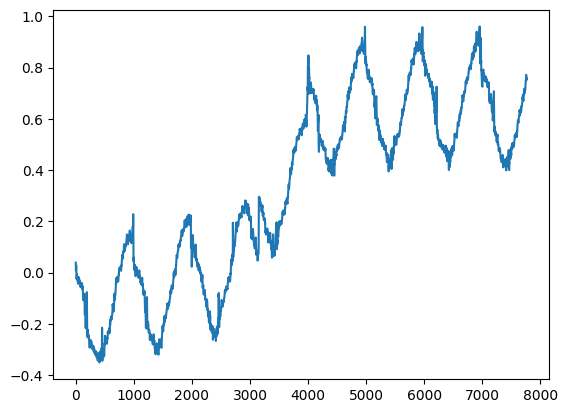

In [14]:
wavelength = 532e-9
centroid_y = np.unwrap(centroid_y)
centroid_y = np.unwrap(phase_kalman)

diff_phase = centroid_y - np.append([centroid_y[0]], np.diff(centroid_y))
plt.plot(tval_vec, centroid_y)
#plt.plot(tval_vec, diff_phase)
z = centroid_y/(2*np.pi)*wavelength/2

plt.figure()
plt.plot(tval_vec, z/1e-6)


### Displacement calc (nano)

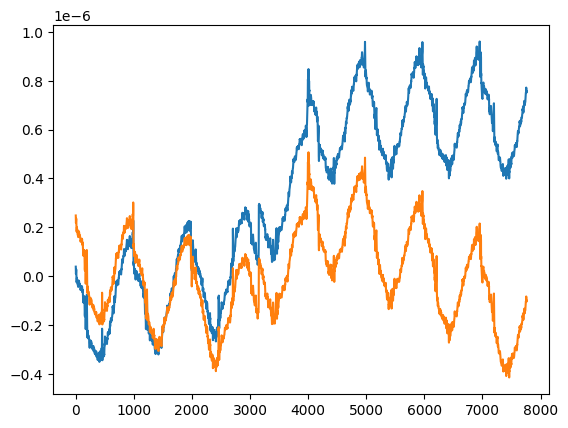

In [20]:
t_step = 1

t_interp = np.arange(tval_vec.min(), tval_vec.max(), t_step)
z_interp = np.interp(t_interp, tval_vec, z)

plt.plot(t_interp, z_interp)

z_detrend = scipy.signal.detrend(z_interp)
plt.plot(t_interp, z_detrend)


### FFT for finding main frequency of the signal

(0.0, 2000.0)

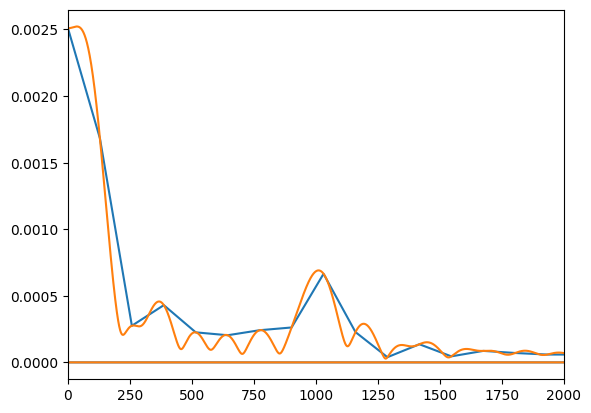

In [16]:
a = np.pad(z_interp, len(z_interp)*2)
a = np.pad(z_interp, 2**20-1)


ft = np.fft.fft(z_interp)
freqs = np.fft.fftfreq(len(ft), d=t_step*1e-6)

plt.plot(freqs, np.abs(ft))

ft = np.fft.fft(a)
freqs = np.fft.fftfreq(len(ft), d=t_step*1e-6)

plt.plot(freqs, np.abs(ft))

plt.xlim(0, 2000)

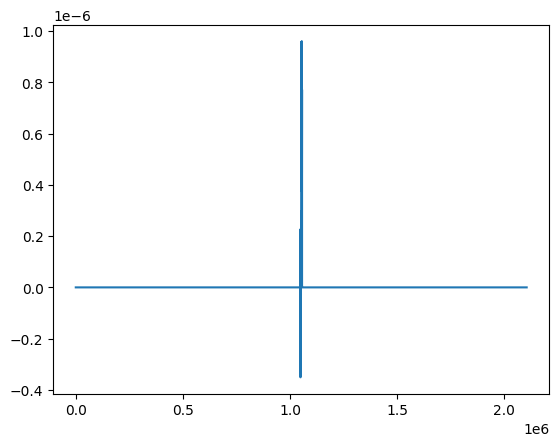

In [17]:
#a = np.pad(z_interp, len(z_interp)*2)

plt.plot(a)